In [1]:
import instruments as inst
import copy
import numpy as np

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [2]:
file_path = "20230914_processed_table.csv"
wavelength_string = 670
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[  4891.    12895.5   -8596.    13342.5    1190.5   12976.    -5411.5
  13045.    -6623.5   13368.5    2486.    12814.   -12740.5   13944.
   9496.5   12967.5  -13235.    13903.    11358.    13094.5   -8040.5
  13293.     7342.5   13117.5    -674.    12906.      334.5   13393.
   3112.    12875.5   -3963.    13650.     4450.    13125.5   -6885.5
  13580.     6726.5   12994.5   -9906.    13737.5    2201.    13172.5
  -6372.5   13278.    -6036.    13547.5    1799.5   12976.5  -12123.5
  14053.     8802.    12981.   -12333.5   13903.    10326.    13109.5
  -7081.    13226.     6317.    13089.     -227.    12805.      -70.5
  13321.5    1057.    13329.    -2102.5   13579.     8027.5   13096.5
  -9776.    13947.5    9101.    13241.   -12201.    13999.     3880.5
  13327.5   -8014.5   13505.5   -4793.5   13695.5     477.5   13135.5
 -10556.    14132.     7209.5   12967.   -10266.    13911.     8276.
  12972.    -4663.    13153.     3708.25  13091.    -2852.   

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [3]:
# Loading in previous fit from vampires_calibration
past_fit = np.load("scipy_minimize_20230914_675nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

theta_pol = past_fit[0]
delta_HWP = past_fit[1]
offset_HWP = past_fit[2]
delta_derot = past_fit[3]
offset_derot = past_fit[4]
delta_opts = past_fit[5]
epsilon_opts = past_fit[6]
rot_opts = past_fit[7]
delta_FLC = past_fit[8]
rot_FLC = past_fit[9]
em_gain = past_fit[10]

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "general_retarder_function",
            "properties": {"phi": 0, "theta": 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": offset_derot},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
        # Testing whether generate_system_mueller_matrix can flag this as a non-existent component
        "test_false_type": {
            "type": "test",
            "properties": {"theta": 0, "epsilon": 0}
        },
        # Testing whether generate_system_mueller_matrix can flag epsilon as a
        # non-existent property of rotator
        "test_false_property": {
            "type": "general_retarder_function",
            "properties": {"epsilon": 0}
        }
    }
}

Past Fit:  [ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]


In [4]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

Error: 'test' is not a valid function in pyMuellerMat.common_mm_functions and will be skipped.
[[0.51859792 0.51785552 0.02773924 0.        ]
 [0.51859792 0.51785552 0.02773924 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# TEST: Checking parse_configuration & update_system_mm

In [5]:
test_configuration = {
    'lp': {'theta': 0.0},
    'hwp': {'theta': 0.0},
    'image_rotator': {'theta': 0.0},
    'flc': {'theta': 0.0},
    'wollaston': {'beam': 'o'}
    }

values, keywords = inst.parse_configuration(test_configuration)
print("Values: " + str(values))
print("Keywords: " + str(keywords))

updated_system_mm = inst.update_system_mm(values, keywords, system_mm)
# print(updated_system_mm.evaluate())


Values: [0.0, 0.0, 0.0, 0.0, 'o']
Keywords: [['lp', 'theta'], ['hwp', 'theta'], ['image_rotator', 'theta'], ['flc', 'theta'], ['wollaston', 'beam']]


# Step 4: Creating a dictionary of p0 starting guesses

In [6]:
# Fittin for just the dichroic for now

p0 = {
    "dichroic": {"phi": 0, "theta": 0}
}

p0_values, p0_keywords = inst.parse_configuration(p0)

# Step 5: Running minimize_system_Mueller_matrix

In [7]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])

result = inst.minimize_system_mueller_matrix(p0, system_mm, interleaved_values, 
    interleaved_stds, configuration_list, s_in = s_in,
    process_dataset = inst.process_dataset, process_errors = inst.process_errors, 
    process_model = inst.process_model)
print(result.x)

p0_values:  [0, 0]
p0_keywords:  [['dichroic', 'phi'], ['dichroic', 'theta']]
Differences:  [  4891.    -8596.     1190.5   -5411.5   -6623.5    2486.   -12740.5
   9496.5  -13235.    11358.    -8040.5    7342.5    -674.      334.5
   3112.    -3963.     4450.    -6885.5    6726.5   -9906.     2201.
  -6372.5   -6036.     1799.5  -12123.5    8802.   -12333.5   10326.
  -7081.     6317.     -227.      -70.5    1057.    -2102.5    8027.5
  -9776.     9101.   -12201.     3880.5   -8014.5   -4793.5     477.5
 -10556.     7209.5  -10266.     8276.    -4663.     3708.25  -2852.
   2511.5    4726.    -5363.5   10531.   -12204.5   10660.   -13704.5
   4702.5   -8856.5   -3889.     -528.    -9262.     5534.    -8036.5
   5551.5   -4715.     3972.    -1018.5     704.     6057.5   -6625.
  10911.   -12521.    10165.   -13204.     3848.5   -8024.    -4414.
    -87.    -8712.     4773.    -3309.     1346.    -5700.     4553.
  -2158.     1607.     4495.    -5147.     8976.   -10466.5    7785.
 -105

# Step 6: Plot model with best fit

[  2.81800024 -10.5021385 ]
[['dichroic', 'phi'], ['dichroic', 'theta']]
Model Length:  160
Configurations List Length:  160
Differences:  [  4891.    -8596.     1190.5   -5411.5   -6623.5    2486.   -12740.5
   9496.5  -13235.    11358.    -8040.5    7342.5    -674.      334.5
   3112.    -3963.     4450.    -6885.5    6726.5   -9906.     2201.
  -6372.5   -6036.     1799.5  -12123.5    8802.   -12333.5   10326.
  -7081.     6317.     -227.      -70.5    1057.    -2102.5    8027.5
  -9776.     9101.   -12201.     3880.5   -8014.5   -4793.5     477.5
 -10556.     7209.5  -10266.     8276.    -4663.     3708.25  -2852.
   2511.5    4726.    -5363.5   10531.   -12204.5   10660.   -13704.5
   4702.5   -8856.5   -3889.     -528.    -9262.     5534.    -8036.5
   5551.5   -4715.     3972.    -1018.5     704.     6057.5   -6625.
  10911.   -12521.    10165.   -13204.     3848.5   -8024.    -4414.
    -87.    -8712.     4773.    -3309.     1346.    -5700.     4553.
  -2158.     1607.     4495

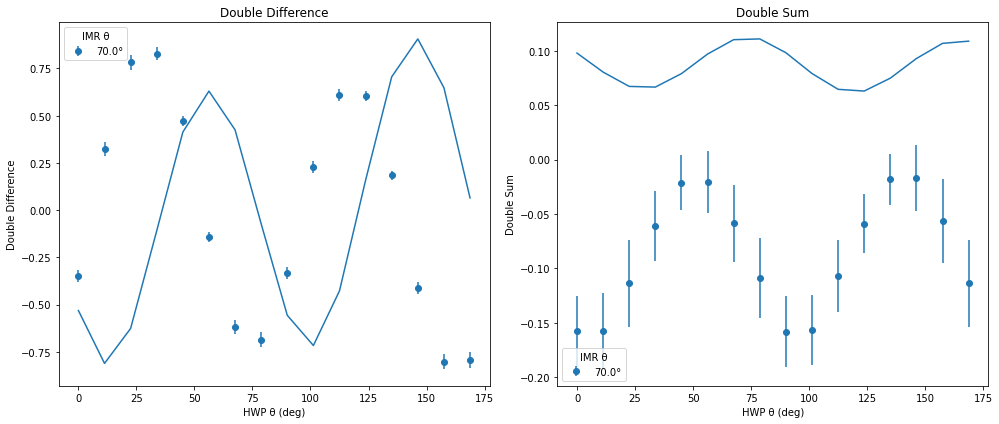

In [9]:
# Generate model with p0 keywords but scipy minimized results
print(result.x)
print(p0_keywords)

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)
print("Model Length: ", len(model))
print("Configurations List Length: ", len(configuration_list))

# print(interleaved_values)

inst.plot_data(interleaved_values, interleaved_stds, model, configuration_list, imr_theta_filter = 70)